# Squential Event Feature Extraction

### OpenStack
OpenStack is a free, open standard cloud computing platform. It is mostly deployed as infrastructure-as-a-service in both public and private clouds where virtual servers and other resources are made available to users.

Log Structure | Description
--- | ---
nova-\___.log | cloud controller
yy-MM-dd_hh-mm-ss | logging date and time
yy-MM-dd hh:mm:ss.ms | logging date and time from the start of logging
_ _ _ _ _ | a 5 digit code (not sure exactly what it represents)
INFO/WARN/DEBUG/ERROR/etc. | type of the logging event and priority
nova.\__.\__.\__ | general source of logging event
\[req -\___ -\___ -\___ -\___ -\___ | virtual machine instance
\___ \___ - - -] | some IDs
\__ . __ . __ . __ | IP address
"\<query / message\>" | log message or api query


Example:
- `nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:00.272 25746 INFO nova.osapi_compute.wsgi.server [req-9bc36dd9-91c5-4314-898a-47625eb93b09 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2577181`

### Import Libraries

In [1]:
# Parsing and wrangling
import pandas as pd
import numpy as np
import regex as re

# misc
from datetime import datetime as dt
import itertools

## HDFS Feature Engineering

In the future, incorporating the time between sequential log events will be considered as it may be a useful feature for improving anomaly detection.

In [7]:
## import raw log data

# full set
#raw = pd.read_csv('All-Data/HDFS/Raw/HDFS.log', header=None, sep='\n')[0]

# sample set
raw = pd.read_csv('../All-Data/HDFS/Raw/HDFS_2k.log', header=None, sep='\n')[0]

raw.head()

0    081109 203615 148 INFO dfs.DataNode$PacketResp...
1    081109 203807 222 INFO dfs.DataNode$PacketResp...
2    081109 204005 35 INFO dfs.FSNamesystem: BLOCK*...
3    081109 204015 308 INFO dfs.DataNode$PacketResp...
4    081109 204106 329 INFO dfs.DataNode$PacketResp...
Name: 0, dtype: object

# OpenStack Feature Engineering

In the future, incorporating the time between sequential log events will be considered as it may be a useful feature for improving anomaly detection.

In [59]:
## import anomaly labels

# since this dataset has only 4 anomalies, we will manually import them
# the non anomalous labels will be appended / parsed directly from the logs
# 1 = anomaly / 0 = normal

vm_labels = pd.DataFrame({'VM_id': ['544fd51c-4edc-4780-baae-ba1d80a0acfc',
                                 'ae651dff-c7ad-43d6-ac96-bbcd820ccca8',
                                 'a445709b-6ad0-40ec-8860-bec60b6ca0c2',
                                 '1643649d-2f42-4303-bfcd-7798baec19f9'],
                      'label': [1, 1, 1, 1]})

length = len(vm_labels)
anomalies = len(vm_labels[vm_labels.label == 1])

print('Length labels: ', length)
print('Anomalies: ', anomalies)
print('% Anomalous: ', round(anomalies/length*100, 2),'%')

vm_labels.head()

Length labels:  4
Anomalies:  4
% Anomalous:  100.0 %


,VM_id,label
0,544fd51c-4edc-4780-baae-ba1d80a0acfc,1
1,ae651dff-c7ad-43d6-ac96-bbcd820ccca8,1
2,a445709b-6ad0-40ec-8860-bec60b6ca0c2,1
3,1643649d-2f42-4303-bfcd-7798baec19f9,1


In [60]:
abnormal_log = pd.read_csv('../All-Data/OpenStack/openstack_abnormal.log', header=None, sep='\n')[0]
normal_log1 = pd.read_csv('../All-Data/OpenStack/openstack_normal1.log', header=None, sep='\n')[0]
normal_log2 = pd.read_csv('../All-Data/OpenStack/openstack_normal2.log', header=None, sep='\n')[0]

# bind
raw = abnormal_log.append(normal_log1.append(normal_log2))

# check lengths add up
print(len(raw) == len(abnormal_log) + len(normal_log1) + len(normal_log2))
print('Events:', len(raw))

True
Events: 207820


In [79]:
## parse for VM IDs
VMs_in_order = raw.str.findall(r'(?<=instance: )[\da-z-]+') # [a-zA-Z\d]{8}-.{4}-.{4}-.{4}-[a-zA-Z\d]{12}

print('Events with >1 VM IDs: ', len(VMs_in_order[VMs_in_order.str.len() > 1]))
print('Events with 1 VM ID:  ', len(VMs_in_order[VMs_in_order.str.len() == 1]))
print('Events with no VM ID: ', len(VMs_in_order[VMs_in_order.str.len() == 0]))
print()

# for events with 0 VM Ids, we will attribute them a `gen_event`
# label to indicate it is a general server event
import uuid
unique_ids_required = len(VMs_in_order[VMs_in_order.str.len() == 0]) 
uuids = []
for i in range(unique_ids_required):
    uuids += [str(uuid.uuid4())+'-gen_event']
VMs_in_order[VMs_in_order.str.len() == 0] = uuids

# for events with 1 VM Id, unlist them
VMs_in_order[VMs_in_order.str.len() == 1] = VMs_in_order[VMs_in_order.str.len() == 1].apply(lambda x: x[0])

print('Were all events captured?  : ', len(VMs_in_order) == len(raw))
print()

VMs_in_order.head()

Events with >1 VM IDs:  0
Events with 1 VM ID:   51553
Events with no VM ID:  156267

Were all events captured?  :  True



0    b41ca736-c9ce-44be-812a-d4ebf8bb68f1-gen_event
1    34a30c36-5da4-472d-b7b3-f98584043d56-gen_event
2              3edec1e4-9678-4a3a-a21b-a145a4ee5e61
3    4a4a7236-78ba-4dda-b711-a0640181335e-gen_event
4              2b590f10-49fd-4ec9-ae41-19596c2f4b25
Name: 0, dtype: object

In [80]:
## extract raw messages after and including the priority status (INFO/WARN/...)
full_msg = raw.str.extract(r'((?=[A-Z]{4}\s).*)')[0]

# extract and join key words without VM IDs
half1 = full_msg.str.findall(r'\A(.+)(?=\s\[)') # first half of message
half2 = full_msg.str.findall(r'[^\]]+$') # second half of message
print('First search complete.')

# combine
df = pd.DataFrame({'half1': half1, 'half2': half2})
full = df.apply(lambda x: "".join(x[0] + x[1]), axis = 1)
print('Combined message halfs.')
    
# vectorized function to join general key words from list to str
toSentence = np.vectorize(lambda x: " ".join(x))

# filter again but strictly for words
sentences = pd.Series(toSentence(full.str.findall(r'(\b[A-Za-z_]+\b)')))
print('Second search complete.')

print('Messages extracted: ', len(sentences))

# this needs to be a relatively small number to work best
# it's a bit too big right now
print('Unique messages: ', len(pd.unique(sentences)))

First search complete.
Combined message halfs.
Second search complete.
Messages extracted:  207820
Unique messages:  2174


In [81]:
from gensim.models import Word2Vec
import nltk
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn import cluster, metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()

In [67]:
## vectorizing sentences

# split sentences into lists of words
sentences_split = list(sentences.apply(lambda x: x.split()))
model = Word2Vec(sentences_split, min_count = 1)

# function to vectorize each sentences
def vectorizer(sent, model):
    vec = model.wv[sent[0]]
    for w in range(1, len(sent)):
        vec = np.add(vec, model.wv[sent[w]])
    return np.asarray(vec) / len(sent)

l = []

# vectorize sentences
for sent in sentences_split:
    l.append(vectorizer(sent, model))

X = np.array(l)

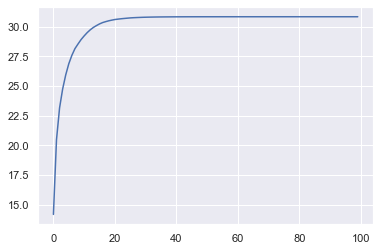

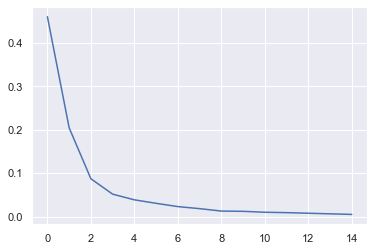

In [68]:
# PCA 
pca = PCA().fit(X)

# cuulative explained variance
plt.plot(np.cumsum(pca.explained_variance_))
plt.show()

# explained variance by component
plt.plot(pca.explained_variance_ratio_[0:15])
plt.show()

# we'll keep the first 20 components then...

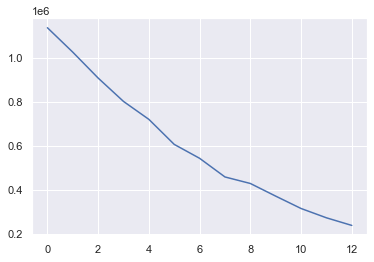

In [69]:
## clustering similar sentences together

# PCA on first 20 components
pca = PCA(n_components = 20).fit(X)
coords = pca.transform(X)

# k means
inertia = []
for c in range(7, 20):
    inertia += [KMeans(n_clusters=c, random_state=1).fit(X).inertia_]

plt.plot(inertia)
plt.show()

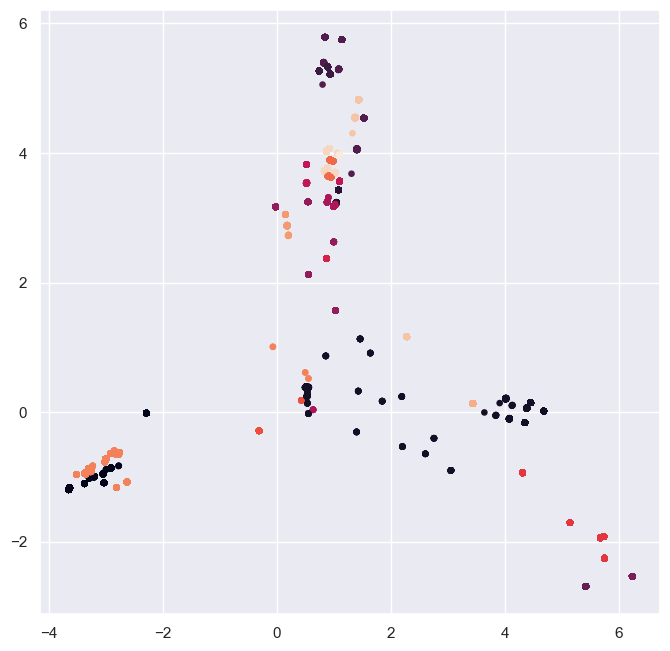

In [70]:
# optimal clusters:
otp_clust = 20

kmeans = KMeans(n_clusters = otp_clust, random_state=1).fit(X)
kmean_clusters = kmeans.fit_predict(coords)

figure(figsize=(8, 8), dpi=100)
plt.scatter(coords[:, 0], coords[:, 1], s = 14, c = kmean_clusters)
plt.show()

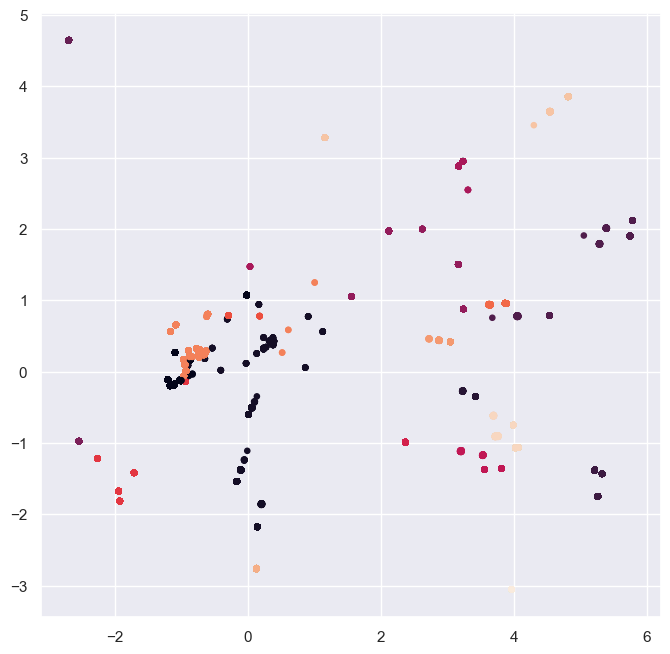

In [71]:
figure(figsize=(8, 8), dpi=100)
plt.scatter(coords[:, 1], coords[:, 2], s = 14, c = kmean_clusters)
plt.show()

In [82]:
## convert general message structure to numeric

coded_events = pd.Categorical(sentences).codes 
kmeans_coded_events = kmean_clusters
#hierarchy_coded_events = hierarchy_clusters

print('Unique All Coded: ', len(pd.Series(coded_events).unique()))
print('Unique Kmeans Coded: ', len(pd.Series(kmeans_coded_events).unique()))
#print('Unique Hierarchy Coded: ', len(pd.Series(hierarchy_coded_events).unique()))


Unique All Coded:  2174
Unique Kmeans Coded:  20


In [83]:
## create final sequetial feature

# VM ID and event codes frame
events = pd.DataFrame({'vm_id': VMs_in_order,
                       'all_cat': coded_events,
                       'kmean_cat': kmeans_coded_events})

# groupby by vm ID to create event sequences 
all_event_sequences = events.groupby('vm_id')['all_cat'].apply(list).reset_index(name='sequence')
kmean_event_sequences = events.groupby('vm_id')['kmean_cat'].apply(list).reset_index(name='sequence')

# label anomalies
vectorized_anom_labeler = np.vectorize(lambda x: 1 if x in set(vm_labels.VM_id) else 0)

all_event_sequences['anomaly'] = pd.Series(vectorized_anom_labeler(all_event_sequences.vm_id))
kmean_event_sequences['anomaly'] = pd.Series(vectorized_anom_labeler(kmean_event_sequences.vm_id))

# export the feature
all_event_sequences.to_csv('../Data/OpenStack/all_event_sequences.csv', index = False, header = True)
kmean_event_sequences.to_csv('../Data/OpenStack/kmean_event_sequences.csv', index = False, header = True)

print(all_event_sequences.head())
print(kmean_event_sequences.head())

                                            vm_id sequence  anomaly
0  00002b40-0521-4894-a34a-b5a27295edd6-gen_event   [1642]        0
1  00006415-d514-4180-8dda-7a6d1783993d-gen_event   [1442]        0
2  00007138-a0a8-4b45-b048-89604549e018-gen_event    [186]        0
3  00009d44-60d2-4d74-b94f-c362e468b525-gen_event   [2143]        0
4  00015c09-4872-468b-ab65-bbf11f45fd74-gen_event   [2139]        0
                                            vm_id sequence  anomaly
0  00002b40-0521-4894-a34a-b5a27295edd6-gen_event      [0]        0
1  00006415-d514-4180-8dda-7a6d1783993d-gen_event      [7]        0
2  00007138-a0a8-4b45-b048-89604549e018-gen_event     [12]        0
3  00009d44-60d2-4d74-b94f-c362e468b525-gen_event      [6]        0
4  00015c09-4872-468b-ab65-bbf11f45fd74-gen_event     [11]        0


In [84]:
## perform a quick check

# how many block IDs in the final dataset?
target_row_count = len(VMs_in_order.unique())
final_row_count = len(all_event_sequences)

# how many anomalies in the final dataset?
original_anomaly_count = 4
final_anomaly_count = len(all_event_sequences[all_event_sequences.anomaly==1])


# if the numbers don't match two things may be happening:
# 1) something went wrong earlier
# 2) you're using the sample dataset

print(f'Total blocks present {final_row_count} of {target_row_count}')
print(f'Total anomalies present {final_anomaly_count} of {original_anomaly_count}')

Total blocks present 158336 of 158336
Total anomalies present 4 of 4
